%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
import tensorflow as tf
#%%
tf.config.list_physical_devices('GPU') 
#%% Read CSV
#First we read the csv to plot the daily confirmed cases
df_3_months = pd.read_csv("california-history.csv",skiprows=range(1,120),nrows=92)
#%% Select Data
#Selecting only the columns for date and US case values
df_3_months = df_3_months[['date', 'positiveIncrease']]
print('\n')
print(df_3_months)



          date  positiveIncrease
0   2020-11-08              7682
1   2020-11-07              5863
2   2020-11-06              6518
3   2020-11-05              4566
4   2020-11-04              5338
..         ...               ...
87  2020-08-13              7085
88  2020-08-12             11645
89  2020-08-11             12500
90  2020-08-10              7751
91  2020-08-09              8373

[92 rows x 2 columns]


2021-11-12 07:11:29.088988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 07:11:29.089423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 07:11:29.176874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 07:11:29.177249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 07:11:29.177557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

%Plotting our first 3 months of data from 3/01/2020 to 5/30/2020

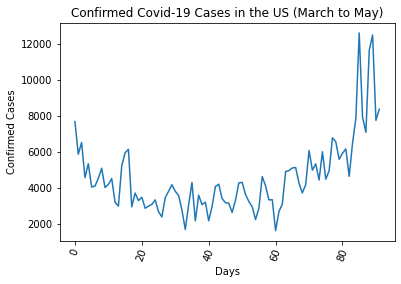

In [2]:
plt.plot(df_3_months['positiveIncrease'])
plt.xlabel('Days')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed Covid-19 Cases in the US (March to May)')
plt.xticks(rotation=70)
plt.show()

% Second we read the csv and use it to create our training sets

In [3]:
df = pd.read_csv("california-history.csv",skiprows=range(1,120),nrows=184)

%creating a dataframe with only the date and US data

In [4]:
df2 = df[['date', 'positiveIncrease']]
print('\n')
print(df2)



           date  positiveIncrease
0    2020-11-08              7682
1    2020-11-07              5863
2    2020-11-06              6518
3    2020-11-05              4566
4    2020-11-04              5338
..          ...               ...
179  2020-05-13              1759
180  2020-05-12              1443
181  2020-05-11              1259
182  2020-05-10              2119
183  2020-05-09              2049

[184 rows x 2 columns]


%Creating a dataframe with only US data

In [5]:
data = df2.filter(['positiveIncrease'])

%converting the dataframe to numpy array

In [6]:
dataset = data.values

%Establishing size of training data set which will be the first 3 months previously plotted<br>
r half (.5) of the total 6 month data

In [7]:
training_data_len = math.ceil(len(dataset)*.5)

caling training set data

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

%Creating training data set

In [9]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(90, len(train_data)):
    x_train.append(train_data[i-90:i,0])
    y_train.append(train_data[i,0])

%Converting training data sets to numpy arrays

In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)

eshaping training set 

In [11]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

%Creating LSTM model

In [12]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))
with strategy.scope():
    model=Sequential()
    model.add(LSTM(400,return_sequences=True,recurrent_activation='selu',kernel_initializer='lecun_normal', input_shape=(x_train.shape[1],1)))
    model.add(LSTM(200,return_sequences=False))
    # model.add(Dense(400,activation="tanh")) #
    # model.add(Dense(100,activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


2021-11-12 07:11:29.755569: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-12 07:11:29.984887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 07:11:29.985239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 07:11:29.985547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


% Compiling model<br>
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy())

%Training the model with our training sets and allowing for single iteration

In [13]:
startTime = datetime.now()
print(startTime,"Starting Fit")
model.fit(x_train, y_train, batch_size=64, epochs=200)
print(datetime.now() - startTime,"Fit Finished")

2021-11-12 07:11:32.680368 Starting Fit
Epoch 1/200


2021-11-12 07:11:32.723194: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_837"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You c

INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-11-12 07:11:39.452185: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-11-12 07:11:40.808639: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2021-11-12 07:11:41.725161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


1/1 [==============================] - 9s 9s/step - loss: 0.1309
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 2/200
1/1 [==============================] - 0s 111ms/step - loss: 0.0387
Epoch 3/200
1/1 [==============================] - 0s 129ms/step - loss: 0.0409
Epoch 4/200
1/1 [==============================] - 0s 146ms/step - loss: 0.0014
Epoch 5/200
1/1 [==============================] - 0s 110ms/step - loss: 0.0223
Epoch 6/200
1/1 [==============================] - 0s 121ms/step - loss: 0.0265
Epoch 7/200
1/1 [==============================] - 0s 115ms/step - loss: 0.0019
Epoch 8/200
1/1 [==============================] - 0s 115ms/step - loss: 0.0082
Epoch 9/200
1/1 [==============================] - 0s 210ms/step - loss: 0.0119
Epoch 10/200
1/1 [==============================] - 0s 110ms/step - loss: 0.0034
Epoch 11/200
1/1 [==============================] - 0s 101ms/step - loss: 

%Creating array for the remaining 3 months of values

In [14]:
test_data = scaled_data[training_data_len-90:, :]

reating test data sets

In [15]:
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(90, len(test_data)):
    x_test.append(test_data[i-90: i,0])

onverting to numpy arrays    

In [16]:
x_test = np.array(x_test)

eshaping test data sets

In [17]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

%Acquiring predicted values based on test data set

In [18]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2021-11-12 07:12:08.137054: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_12155"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:627"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Y

Instructions for updating:
use `experimental_local_results` instead.


lotting trained, validated, and finally predicted data

/tmp/ipykernel_25542/198054223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions


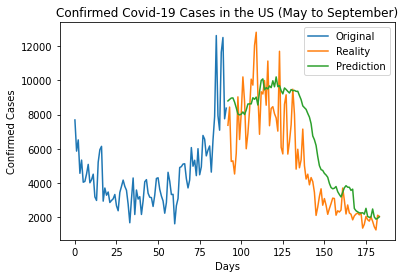

In [19]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions']=predictions
plt.title('Confirmed Covid-19 Cases in the US (May to September)')
plt.xlabel('Days')
plt.ylabel('Confirmed Cases')
plt.plot(train['positiveIncrease'])
plt.plot(valid[['positiveIncrease','Predictions']])
plt.legend(['Original', 'Reality', 'Prediction'])
plt.show()
# %%

%%